# Project: Bosch Manufacturing Line

## I. Exploratory Analysis

------

__Author:__ [Ryan Harper](www.kimrharper.com) <br><br>
__Data Source:__ [Bosch Dataset via Kaggle](https://www.kaggle.com/c/bosch-production-line-performance/data) <br> <br>
__Background:__ Bosch is a home appliance and industrial tools manufacturing company. In 2017, Bosch supplied Kaggle.com with manufacturing data to promote a competition. The goal of the competition was to determine factors that influence whether or not the product passes the final response stage of manufacturing and to predict which products are likely to fail based on this manufacturing process.<br> <br>
__The Data:__ Early exploration of this data will use a subset of the big data provided by Bosch. The data is provided by [Hitesh, John, and Matthew via PDX Data Science Meetup](https://www.meetup.com/Portland-Data-Science-Group/events/257370691/). The data subset is divided into 2 groups of 3 files (3 training, 3 test). Each group has one csv file each for numerical features ('numeric'), dates ('date'), and the manufacturing path ('cat'). The data subset includes a larger percentage of products that failed the response test, but not much more is known about this subsampling method.<br><br>
__Assumptions:__ ID # represents a specific product and that there is only one product. The differences in assembly are due to customization and/or differences between lines.<br><br>
__Goal:__ Predict which products will fail the response test. <br><br>

----

In [72]:
# imports
import pandas as pd; import missingno as msno; import matplotlib.pyplot as plt; import seaborn as sns;import numpy as np;import warnings
from sklearn import preprocessing; from scipy import stats; import networkx as nx; from IPython.display import Image
from networkx.drawing.nx_agraph import graphviz_layout,from_agraph, to_agraph; import graphviz
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt


# settings
np.seterr(divide='warn', invalid='warn'); sns.set_style("whitegrid");warnings.filterwarnings('ignore')

In [73]:
# debug
import_fail=False
exec("try: import pygraphviz as pgv\nexcept: problem=import_fail = True")

-----

### A. Numerical Data

In [74]:
%%time
# import numerical data
mf_num_data = pd.read_csv('bosch_small_data/train_numeric.csv',low_memory=False)

CPU times: user 10.4 s, sys: 1.88 s, total: 12.3 s
Wall time: 13 s


As the data is extremely large, it is important to explore the structure of the data to get a feel for what is happening. The numerical data appears to be the most important, so I will start with examining the numerical data.

In [4]:
# show data with pandas
mf_num_data.head(2)

,Id,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F8,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,...,L3_S50_F4245,L3_S50_F4247,L3_S50_F4249,L3_S50_F4251,L3_S50_F4253,L3_S51_F4256,L3_S51_F4258,L3_S51_F4260,L3_S51_F4262,Response
0,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,71,-0.167,-0.168,0.276,0.33,0.074,0.161,0.052,0.248,0.163,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


There are a lot of missing data and null (NaN) values. It is not obvious if this is due to recording errors (which I suspect is not the case), or if it is related to the structuring of the data. I need to continue visualizing the data.

<Figure size 432x288 with 0 Axes>

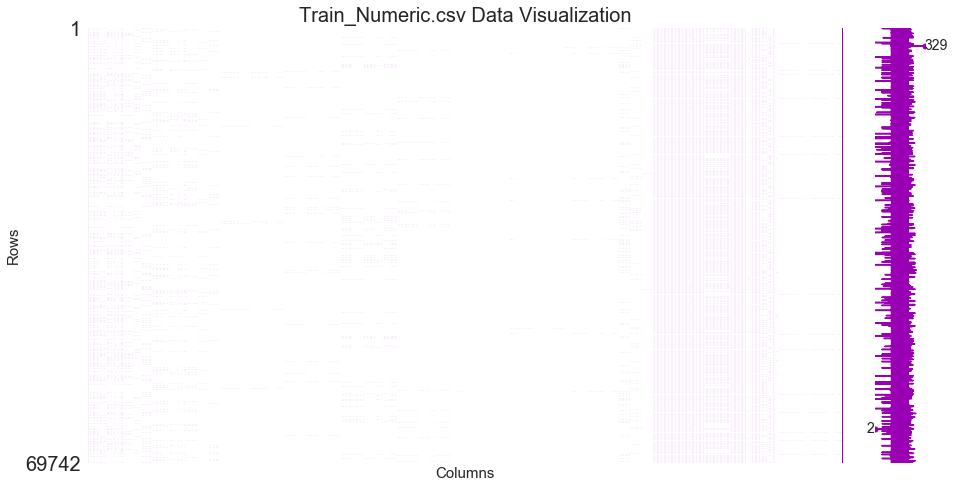

In [5]:
# visualize numerical data with missingno
plt.figure()
msno.matrix(mf_num_data, color=(.6,0,.7),figsize=(15,8))
plt.title('Train_Numeric.csv Data Visualization',size=20)
plt.ylabel('Rows',size=15)
plt.xlabel('Columns',size=15)
plt.show()

#msno.dendrogram(mf_num_data)

The graph above shows which values are included (purple) and which values are missing (white). The final column on the right side of the graph shows how many values are included in each row. Every row appears to have at most 20-30% of the columns filled in with values. This graph confirms that the data set is very sparse and reaffirms explanations of the data from the Kaggle site and from Hitesh's presentation on the data. 

In [6]:
# split the strings
columns_set = list(mf_num_data.columns)[1:-1]
breakup_strings = [i.split('_') for i in columns_set]

# store the values in separate containers
line_count = set([i[0] for i in breakup_strings[0:-1]])
station_count = set([i[1] for i in breakup_strings[0:-1]])
feature_count = set([i[2] for i in breakup_strings[0:-1]])

print('Unique lines: {}\nUnique Stations: {}\nUnique Feature Measurements: {}'.format(
    len(line_count),len(station_count),len(feature_count)))

Unique lines: 4
Unique Stations: 50
Unique Feature Measurements: 967


In [7]:
%%time
# function for calculating ratio of failures
def get_ratio(column):
    all_response = mf_num_data[[column,'Response']].dropna()['Response']
    return [column, all_response.sum()/len(all_response)]

# calculate ratio of failures for every columns
vals = [get_ratio(i) for i in mf_num_data.columns[1:-1]]

# sort values and push to df
sorted_corr = pd.DataFrame(vals).sort_values(by=[1],ascending=False)

CPU times: user 5.01 s, sys: 91.3 ms, total: 5.1 s
Wall time: 5.57 s


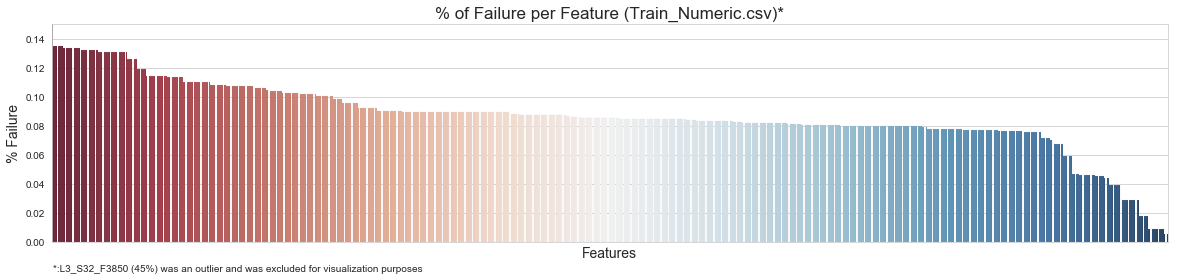

In [8]:
plt.figure(figsize=(20,4))
sns.barplot(x=0,y=1,data=sorted_corr,palette="RdBu",linewidth=.1,edgecolor=".8",orient='v')
plt.xticks([])
plt.xlabel('Features',size=14)
plt.ylabel('% Failure',size=14)
plt.ylim(0,.15)
plt.title('% of Failure per Feature (Train_Numeric.csv)*',size=17)
plt.text(1,-.02, '*:L3_S32_F3850 (45%) was an outlier and was excluded for visualization purposes')
plt.show()

### B. Timeseries Data

In [9]:
%%time
# import date data
mf_date_data = pd.read_csv('bosch_small_data/train_date.csv',low_memory=False)

CPU times: user 11 s, sys: 1.39 s, total: 12.4 s
Wall time: 12.5 s


In [10]:
# show data
mf_date_data.head(3)

,Id,L0_S0_D1,L0_S0_D3,L0_S0_D5,L0_S0_D7,L0_S0_D9,L0_S0_D11,L0_S0_D13,L0_S0_D15,L0_S0_D17,...,L3_S50_D4248,L3_S50_D4250,L3_S50_D4252,L3_S50_D4254,L3_S51_D4255,L3_S51_D4257,L3_S51_D4259,L3_S51_D4261,L3_S51_D4263,Response
0,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,71,1458.06,1458.06,1458.06,1458.06,1458.06,1458.06,1458.06,1458.06,1458.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [11]:
def final_time(df,row_ind):
    time = df.iloc[row_ind,1:].dropna().iloc[-2]
    response = df.iloc[row_ind,-1]
    return time,response

In [12]:
%%time
last_time =[]
for i in range(len(mf_date_data.iloc[:,1:-1])):
    try:
        lt, sc = final_time(mf_date_data,i)
        last_time.append(lt)
    except:
        last_time.append(0)
mf_date_data['final_time'] = last_time
time_series_plot = mf_date_data[['final_time','Response']]

CPU times: user 1min 12s, sys: 1.16 s, total: 1min 13s
Wall time: 1min 14s


<br>In order to visualize the time data, I decided to capture the final time recorded from each row. By sampling the data via the final time that was recorded, it allows us to visualize the time value as a distribution. Below is a visualization of the time data starting at time 0 and ending near 2000:

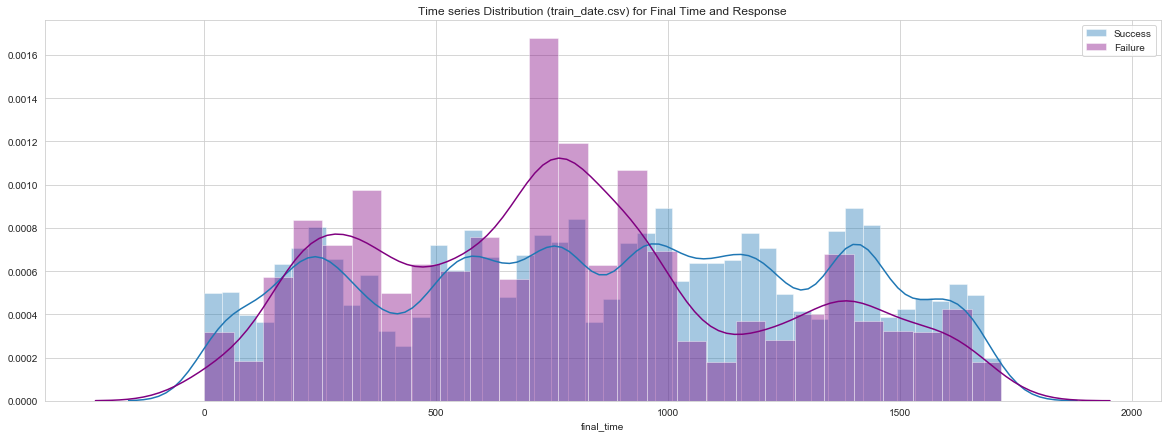

In [13]:
plt.figure(figsize=(20,7))
sns.distplot(time_series_plot['final_time'][time_series_plot['Response']==0])
sns.distplot(time_series_plot['final_time'][time_series_plot['Response']==1],color='purple')
plt.title('Time series Distribution (train_date.csv) for Final Time and Response')
plt.legend(['Success','Failure'])
plt.show()

### C. Graph/Network Data

Now that the numerical data and the date data have been visualized, the next step is to take a look 

Imported categorical data but it doesn't appear to be very useful. Instead of looking at the categorical data, let's look at the numerical data and categorize it via the null value spaces.

In [45]:
%%time
# function source: https://stackoverflow.com/questions/480214/how-do-you-remove-duplicates-from-a-list-whilst-preserving-order
def q_rem_dup(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

CPU times: user 7 µs, sys: 1 µs, total: 8 µs
Wall time: 11.9 µs


In [57]:
# checking_sets
new_sets = [set(['_'.join(feature_member.split('_')[0:2]) for feature_member in list(mf_num_data.iloc[i,1:-1].dropna().index)]) for i in range(6000)]
ordered_stations = frozenset().union(*new_sets);

In [210]:
from sklearn.preprocessing import RobustScaler, StandardScaler, Normalizer
import matplotlib as mpl
import matplotlib.cm as cm

In [50]:
# success fail count
fail_count_station = []

# creating adjacency form numerical data
row_count = len(mf_num_data)
network_structure = []
for i in range(row_count):
    feature_group = ['_'.join(feature_member.split('_')[0:2]) for feature_member in list(mf_num_data.iloc[i,1:-1].dropna().index)]
    feature_group = q_rem_dup(feature_group)
    network_structure.append(feature_group)
    
# create adjacency.txt for easy import
file = open('adjaceny.txt','w') 
for l in network_structure:
    if len(l) > 1:
        file.write(' '.join(l)+'\n')
file.close() 

In [285]:
station_fail_ratio = {}
station_name, station_count=[],[]

for i in ordered_stations:
    total_count = 0
    fail_count = 0
    for m in mf_num_data.columns[1:-1]:
        if i in m:
            df_temp = mf_num_data[np.isfinite(mf_num_data[m])]
            fail_count+=df_temp['Response'][df_temp['Response']==1].sum()
            total_count+=len(df_temp['Response'])
    station_count.append(fail_count/total_count)
    station_name.append(i)
station_count = np.array(station_count)
# station_count = (station_count-station_count.min())/(station_count.max()-station_count.min())

In [393]:
new_array = []
[new_array.append(i) for i in station_count[:-15]];
[new_array.append(i) for i in station_count[-14:]];
get_vals = np.array(new_array)
min_tick = get_vals.min()
max_tick = get_vals.max()

In [348]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.cm import ScalarMappable

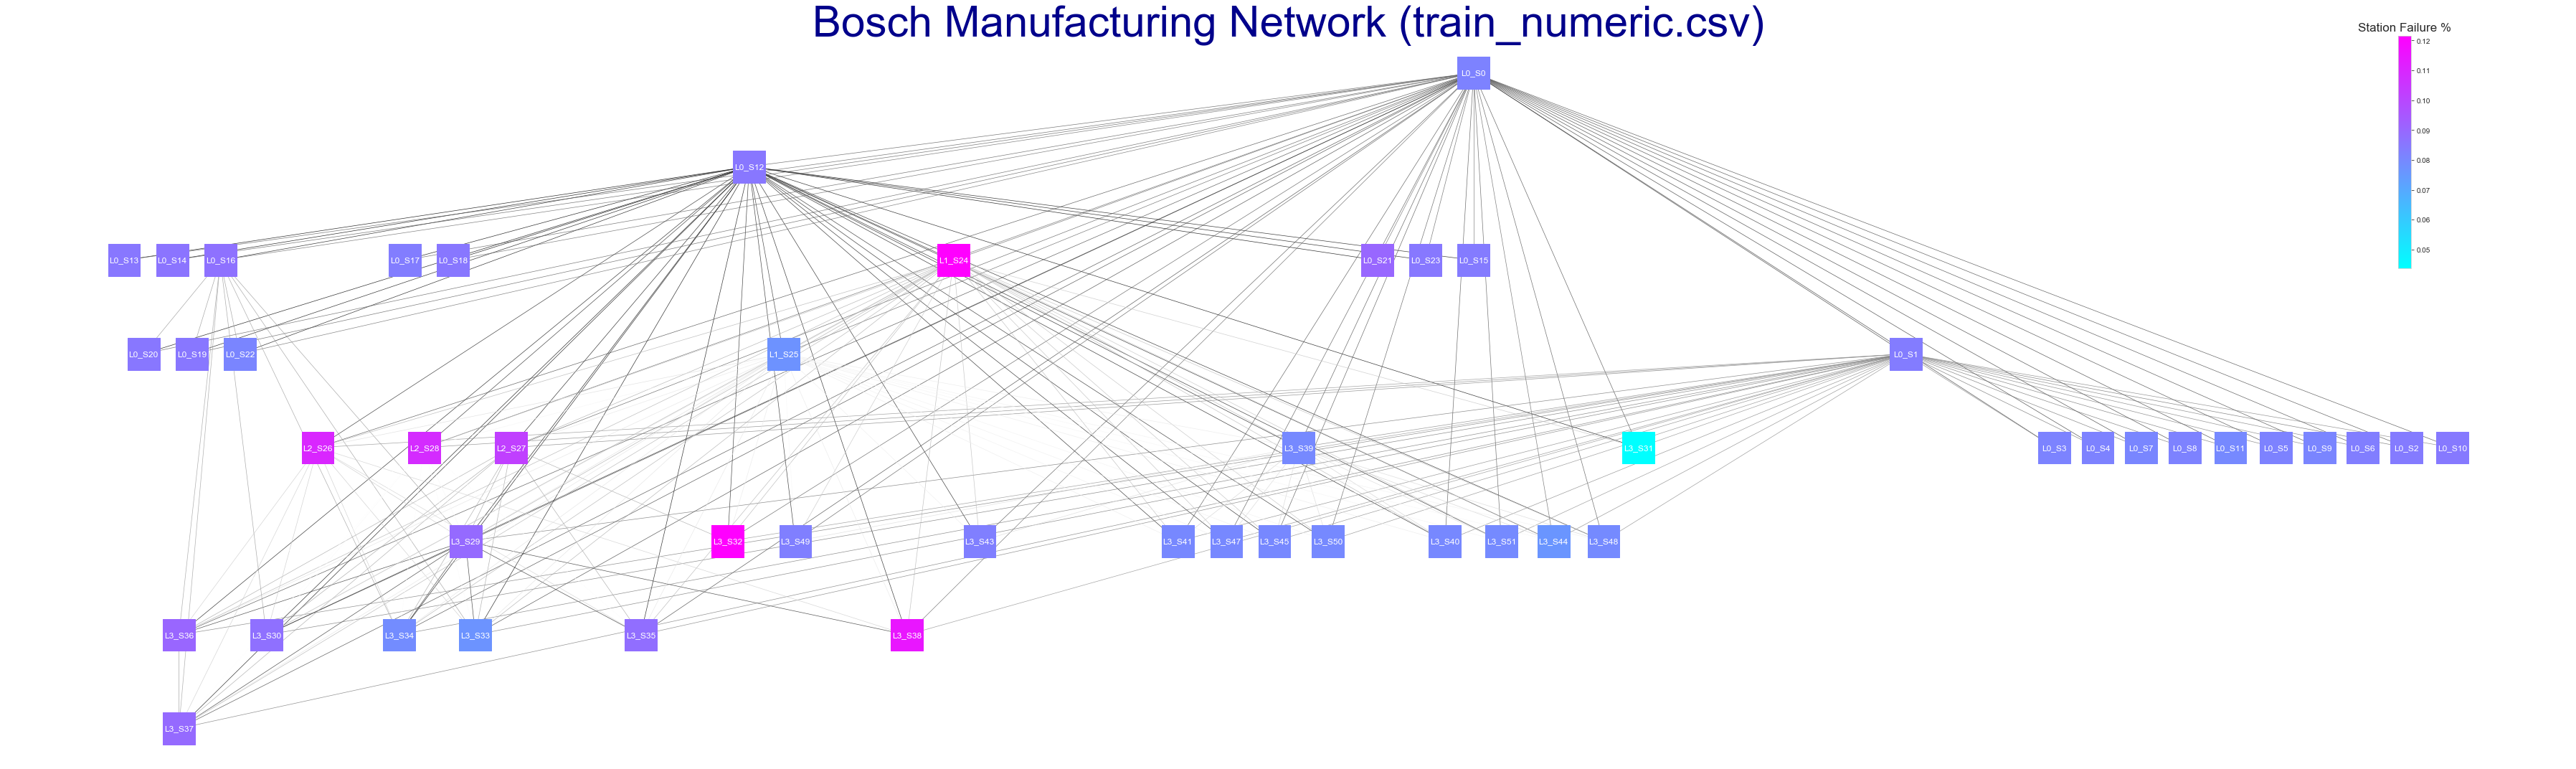

In [396]:
station_dict = {}
for i in range(len(normed_new_s)):
    station_dict[station_name[i]] = station_count[i]
    
norm = mpl.colors.Normalize(vmin=min_tick, vmax=max_tick)
cmap = cm.cool
m = cm.ScalarMappable(norm=norm, cmap=cmap)
colr_check = [m.to_rgba(station_dict[n]) for n in list(G.nodes)]

# Convert txt to networkx
G=nx.read_adjlist("adjaceny.txt", create_using=nx.DiGraph) # A=to_agraph(G)

if import_fail: # if pygraphviz can't load 
    display(Image(filename='network_modeling2.png')) 
else: # if pygraphviz does load
    fig = plt.figure(figsize=(50,15))

    pos = graphviz_layout(G, prog='dot')
    
    # edge
    nx.draw_networkx_edges(G,
                           pos=pos, 
                           alpha=.81,
                           width=.7,
                           arrows=False,
                           arrowsize=10,
                           edge_color=range(len(G.edges)),
                           edge_cmap=plt.cm.gray
                           )

    # node
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_size=2000, 
                           node_shape = 's',
                           node_color=colr_check,
                           alpha=1)

    # labels
    nx.draw_networkx_labels(G,
                            pos=pos,
                            font_color='white')

    plt.title('Bosch Manufacturing Network (train_numeric.csv)',size=60,color='darkblue')
    plt.box(on=None)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    
    cmap = plt.get_cmap("cool")
    norm = plt.Normalize(station_count.min(), station_count.max())
    sm =  ScalarMappable(norm=norm, cmap=cmap)
    m.set_array([])
    cbaxes = fig.add_axes([.93,.65, 0.005, 0.3]) 
    cbar = plt.colorbar(m,cax=cbaxes)
    cbar.ax.set_title("Station Failure %",size=17)
    plt.savefig('network_modeling3.png',bbox_inches='tight')
    plt.show()

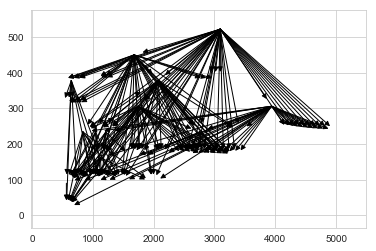

In [401]:
edges=nx.draw_networkx_edges(G,pos=pos)

<class 'matplotlib.patches.FancyArrowPatch'>
<class 'matplotlib.patches.FancyArrowPatch'>
<class 'matplotlib.patches.FancyArrowPatch'>
<class 'matplotlib.patches.FancyArrowPatch'>
<class 'matplotlib.patches.FancyArrowPatch'>
<class 'matplotlib.patches.FancyArrowPatch'>
<class 'matplotlib.patches.FancyArrowPatch'>
<class 'matplotlib.patches.FancyArrowPatch'>
<class 'matplotlib.patches.FancyArrowPatch'>
<class 'matplotlib.patches.FancyArrowPatch'>
<class 'matplotlib.patches.FancyArrowPatch'>
<class 'matplotlib.patches.FancyArrowPatch'>
<class 'matplotlib.patches.FancyArrowPatch'>
<class 'matplotlib.patches.FancyArrowPatch'>
<class 'matplotlib.patches.FancyArrowPatch'>
<class 'matplotlib.patches.FancyArrowPatch'>
<class 'matplotlib.patches.FancyArrowPatch'>
<class 'matplotlib.patches.FancyArrowPatch'>
<class 'matplotlib.patches.FancyArrowPatch'>
<class 'matplotlib.patches.FancyArrowPatch'>
<class 'matplotlib.patches.FancyArrowPatch'>
<class 'matplotlib.patches.FancyArrowPatch'>
<class 'ma

In [ ]:
mf_network = mf_num_data.where(mf_num_data.isnull(), 1).fillna(0).astype(int)
del mf_network['Id']
del mf_network['Response']

In [ ]:
mf_network.head(2)

### D. Failed Product Exploration

In [ ]:
mf_num_data[mf_num_data['response'] == 0].describe()

In [ ]:
mf_num_data[mf_num_data['Response'] == 1].head()

In [ ]:
features = mf_num_data.columns[1:-1]

In [ ]:
success_mean = [mf_num_data[f][mf_num_data['Response']==0].mean() for f in features]
fail_mean = [mf_num_data[f][mf_num_data['Response']==1].mean() for f in features]
real_mean = [mf_num_data[f].mean() for f in features]

In [ ]:
mean_check = pd.DataFrame(data=[success_mean,fail_mean,real_mean]).T
mean_check['features'] = features
mean_check.columns = ['success_m','fail_m','real_mean','features']
mean_check_reduced = mean_check[0:15]

fig = plt.figure(figsize=(20,10))
sns.barplot(data=mean_check_reduced, x='features', y='fail_m', color='purple',)
sns.barplot(data=mean_check_reduced, x='features', y='success_m', color='lightblue')
plt.title('Comparing Mean Values of Failed vs Successful')
fail = mpatches.Patch(color='purple', label='Fail')
success = mpatches.Patch(color='lightblue', label='Success')
plt.legend(handles=[fail,success])
plt.show()